<a href="https://colab.research.google.com/github/Vaishnav0915/RCS-SFP/blob/main/RCSSFP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn prophet openpyxl

In [9]:
from google.colab import files
uploaded = files.upload()

Saving online_retail_II.xlsx to online_retail_II.xlsx


In [10]:
import pandas as pd
df= pd.read_excel('online_retail_II.xlsx',sheet_name='Year 2009-2010')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [13]:
#DATA CLEANING

#dropping rows with customer id
df.dropna(subset=['Customer ID'],inplace=True)
#removing canlled orders
df=df[~df['Invoice'].astype(str).str.startswith('C')]
#filter +ve quantity and price
df=df[(df['Quantity']>0)&(df['Price']>0)]
#create totalprice column
df['TotalPrice']=df['Quantity']*df['Price']

**EXPLORATORY DATA ANALYTICS**

EDA reveals patterns, trends, and business opportunities

Key analyses:
*   Monthly sales trebds
*   Top-selling Products
*   Top revenue-generating countries

<ipython-input-15-22b5cb9aa7fc>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ms=df.set_index('InvoiceDate').resample('M')['TotalPrice'].sum()


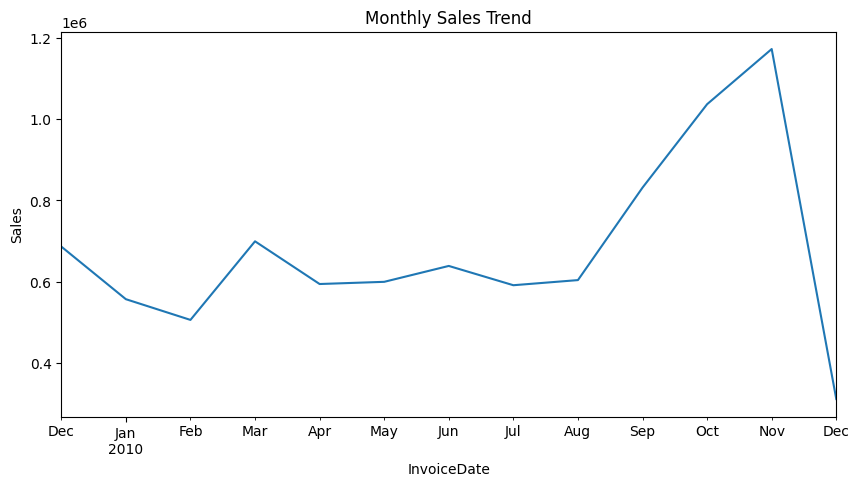

In [15]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

#monthly sales
ms=df.set_index('InvoiceDate').resample('M')['TotalPrice'].sum()

import matplotlib.pyplot as plt
ms.plot(figsize=(10,5), title='Monthly Sales Trend')
plt.ylabel('Sales')
plt.show()


In [16]:
#total products by revenue
top_products_by_revenue=df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)
print(top_products_by_revenue)

Description
WHITE HANGING HEART T-LIGHT HOLDER     151624.31
REGENCY CAKESTAND 3 TIER               143893.35
Manual                                  98560.64
ASSORTED COLOUR BIRD ORNAMENT           70493.83
JUMBO BAG RED RETROSPOT                 51759.30
POSTAGE                                 48741.08
ROTATING SILVER ANGELS T-LIGHT HLDR     40186.65
PAPER CHAIN KIT 50'S CHRISTMAS          36933.50
PARTY BUNTING                           35035.90
EDWARDIAN PARASOL NATURAL               34044.75
Name: TotalPrice, dtype: float64


In [17]:
#top products by quantity sold
top_products_by_quanity = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
print(top_products_by_quanity)

Description
WHITE HANGING HEART T-LIGHT HOLDER    56915
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54754
BROCADE RING PURSE                    48166
PACK OF 72 RETRO SPOT CAKE CASES      45156
ASSORTED COLOUR BIRD ORNAMENT         44551
60 TEATIME FAIRY CAKE CASES           35806
PACK OF 60 PINK PAISLEY CAKE CASES    31006
JUMBO BAG RED RETROSPOT               29578
SMALL POPCORN HOLDER                  25718
BLACK AND WHITE PAISLEY FLOWER MUG    25685
Name: Quantity, dtype: int64


**Visualizing TOP 10**

```
# This is formatted as code
```



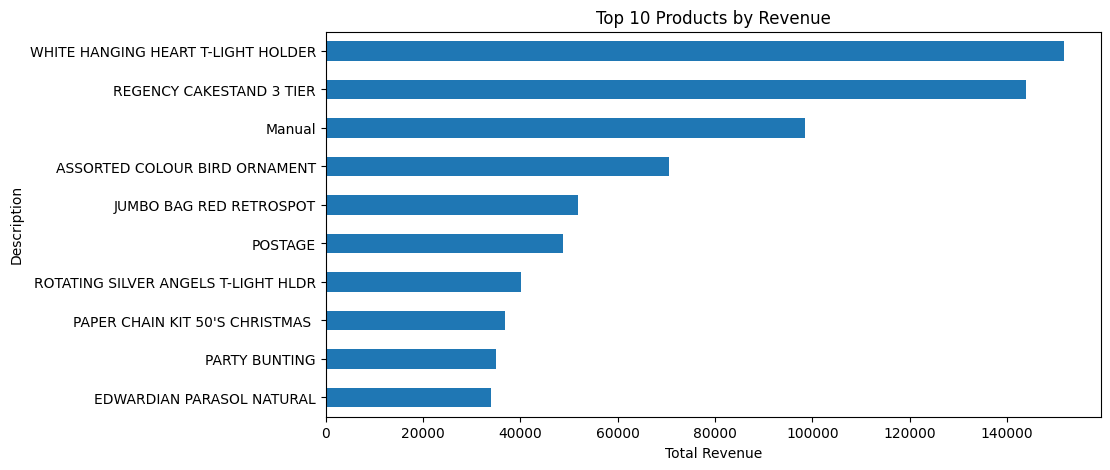

In [18]:
#top by revenue
top_products_by_revenue.plot(kind='barh',figsize=(10,5),title='Top 10 Products by Revenue')
plt.xlabel('Total Revenue')
plt.gca().invert_yaxis()
plt.show()

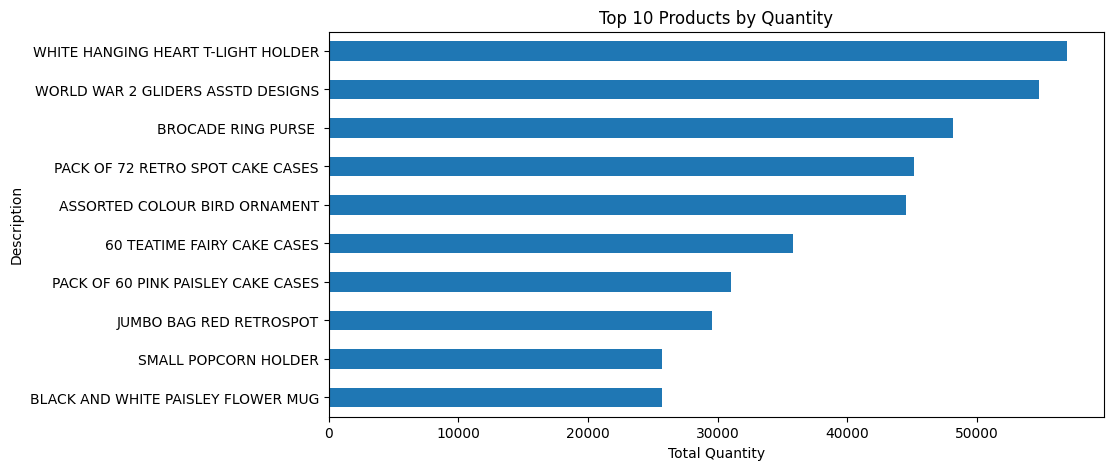

In [19]:
#top by quantity
top_products_by_quanity.plot(kind='barh',figsize=(10,5),title='Top 10 Products by Quantity')
plt.xlabel('Total Quantity')
plt.gca().invert_yaxis()
plt.show()

**RFM Segmentation**

Segmenting customers by Recency, Frequency and Monetary Value helps in targeted marketing

*   Recency: How recently a customer purchased (lower is better)
*   Frequency: How often they purchased (higher is better)
*   Monetary: Total spent (higher is better)

In [23]:
snapshot_date=df['InvoiceDate'].max()+pd.Timedelta(days=1)
rfm=df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x:(snapshot_date-x.max()).days,
    'Invoice':'nunique',
    'TotalPrice':'sum'
})
rfm.columns=['Recency','Frequency','Monetary']
rfm=rfm[rfm['Monetary']>0]
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93


**Clustering Customers**
Use K-Means Clustering to group into similar segments(e.g., loyal customers, high spenders, new customers).

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm.head()

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.0,165,11,372.86,2
12347.0,3,2,1323.32,0
12348.0,74,1,222.16,0
12349.0,43,3,2671.14,0
12351.0,11,1,300.93,0


1. Scatter Plot: Recovery vs Frequency, Colored by cluster

Visually understand how clusters are distributed across two important dimensions: How recently and how often customers purchased

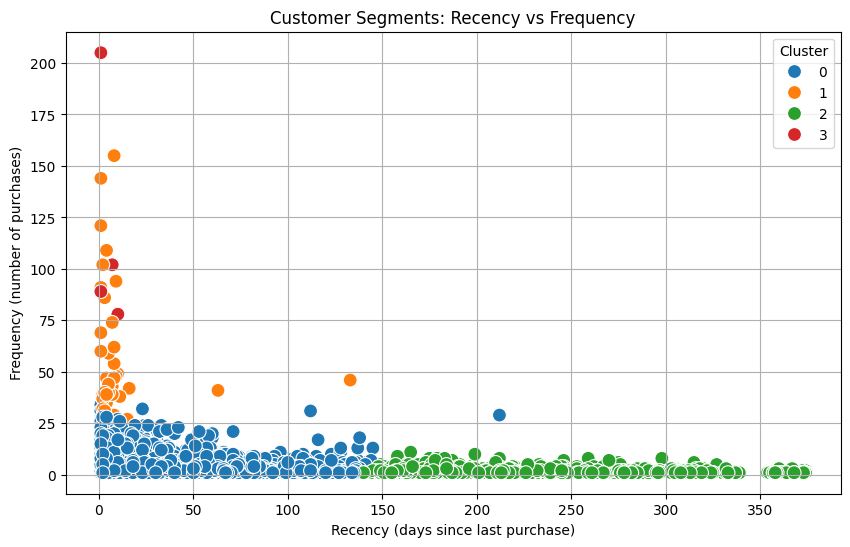

In [25]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Recency',y='Frequency',hue='Cluster', palette='tab10',s=100)
plt.title('Customer Segments: Recency vs Frequency')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Frequency (number of purchases)')
plt.grid(True)
plt.show()

2. Bar Plot: Average Monetary Value by Cluster

Shows which cluster of customers is the most profitable in terms of spending

Cluster
3    236568.790000
1     34941.290053
0      1842.342310
2       595.825575
Name: Monetary, dtype: float64


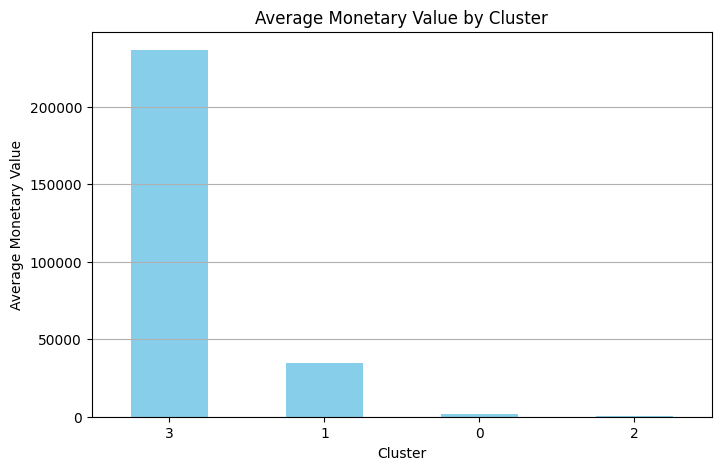

In [29]:
#avg monetary value per cluster
monetary_by_cluster=rfm.groupby('Cluster')['Monetary'].mean().sort_values(ascending=False)
print(monetary_by_cluster)

#plot
plt.figure(figsize=(8,5))
monetary_by_cluster.plot(kind='bar',color='skyblue')
plt.title('Average Monetary Value by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Monetary Value')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

**Time Series Forecasting (with Prophet)**


Forecasting help businesses predict the future sales, manage inventory, and plan promotions.

Steps:
*   Aggregate total sales by Month
*   Feed into facebook prophet
*   Visualize the forecast

<ipython-input-31-4e5371fc468d>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sales = df.set_index('InvoiceDate').resample('M')['TotalPrice'].sum().reset_index()
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpryrdflrq/g_hkgmgp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpryrdflrq/pwds0hdi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2347', 'data', 'file=/tmp/tmpryrdflrq/g_hkgmgp.json', 'init=/tmp/tmpryrdflrq

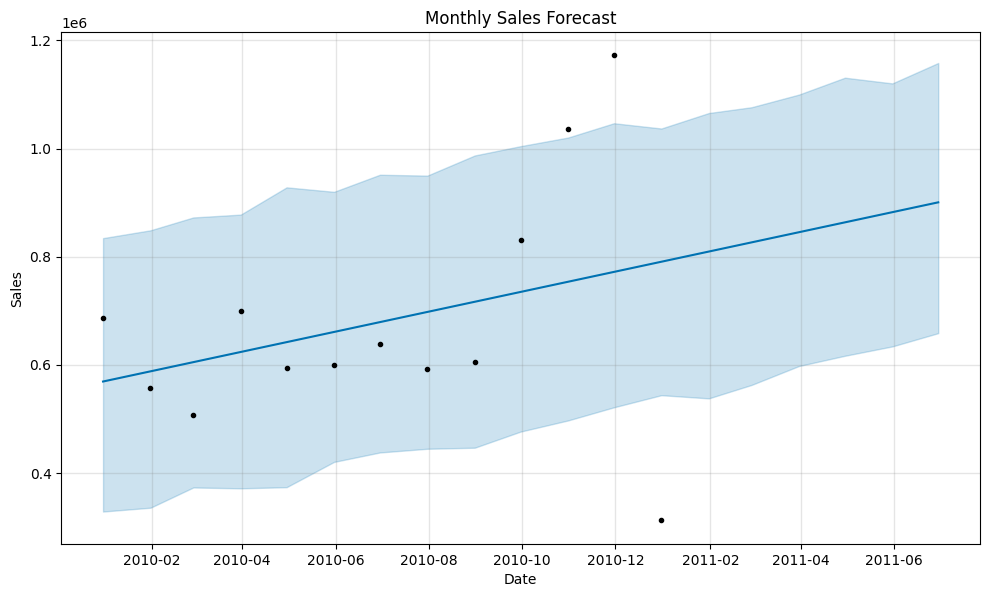

In [31]:
from prophet import Prophet

#monthly sales
sales = df.set_index('InvoiceDate').resample('M')['TotalPrice'].sum().reset_index()
sales.columns = ['ds','y']
model=Prophet()
model.fit(sales)

future = model.make_future_dataframe(periods=6,freq='M')
forecast=model.predict(future)

model.plot(forecast)
plt.title('Monthly Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

**Dashboarding (Optional but Powerful)**

Visual dashboards in Power BI/Tableau make your project recruiter- and stakeholder-friendly.